# Create a plot of Lab Analysis Results for all months this year

In [ ]:
# This program helps you generate the dataframe for each month per area of sampling

In [247]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.parser import parse
from itertools import compress
from collections import OrderedDict
from datetime import date
import datetime
import re
from datetime import timedelta
import openpyxl
from sklearn.metrics import mean_squared_error
import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots

#---------------------
#
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time
#
#-------------------
#
def ave_filler(dfname, colname):
    dfcn = dfname[colname]
    try:        
        dfcn = pd.to_numeric(dfcn, errors='coerce')
    except:
        print('error found in' + str(colname))
        pass
    try:
        dfname[colname] = dfcn.where(dfcn.notnull(), other=(dfcn.fillna(method='ffill') + dfcn.fillna(method='bfill'))/2)
    except:
        print('nan not fixed' + str(colname))   
    return dfname

#----------------------
#
#generate_df_from_analysis: this function creates dataframe by getting laboratory results by taking the excel values from
#    every row in a specified analysis column. An example of analysis column is the column for Zn AAS analysis for NTRL.
#    The critical part of this code is in making sure that the dates and time from the laboratory analysis excel file are
#    parsed and converted into the correct datetime format.
def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df
#-----------------------------------------------------End----------------------------------------------------------------
#
#
#------------------------------------------------------------------------------------------------------------------------
#
def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#
#----------------------------------------------------End-----------------------------------------------------------------
#
#
class LabResults():
    def __init__(self, monthyear, filePath):
        #____monthyear format examle is datetime.date(2020,7,1)
        #____filepath example is '\\thgobna001\userdata\THPAL\...\ANALYSIS RESULTS 2020\7) July _2020.xlsx'
        #____add r' at the start of the filepath to apply the regex that allows the use of the filepath as raw
        #____sef.workbook is the uploaded excel workbook of the entire analysis files so it takes time to load
        #____Create an instance of the workbook by giving it a varible name with the sample format: Jan_2020
        
        import openpyxl
        import io
        with open(filePath, "rb") as f:
            in_mem_file = io.BytesIO(f.read())
        
        self.workbook = openpyxl.load_workbook(in_mem_file, data_only=True)
        self.monthyear = monthyear   
        
    def generate_df_from_analysis(self, tabname, list_lab_index):
        #____tabname is a string type name of the tab in the laboratory analysis excel file.
        #____-------Example tabnames: '104PU01', '105TK03', '106TK01'
        #____-------Inside these tabs are the specific analysis results done on the sample taken from the 'tabname' area .
        #____list_lab_index is a list with the sample format is: ['B', 'C', 'E', '104_Pb']
        #____-------the first letter 'B' is the column letter where the day of the month is written as integers 1,2,3..30
        #____-------the second letter 'C' is the column letter where the sampling time is written; e.g. '7:00:00 AM'
        #____-------the third letter 'E' is the column where the results of the specific analysis are listed
        #____-------the last item in the list is the string you'll use as the new title; e.g. '104_Pb'
        
        workbookTab = self.workbook[tabname]
        self.list_lab_index = list_lab_index
        col_sampleDate = self.list_lab_index[0]
        col_sampleTime = self.list_lab_index[1]
        col_analysis = self.list_lab_index[2]
        col_title = self.list_lab_index[3]
        currentmonthyr = self.monthyear
        
        #get the start and end sample dates
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
        #gets the date day from the B column of the analysis file if there is value in the cell
        for i in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
                Smpl_day_index.append(i)
        #get the ending row that has date day
        for j in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
                smpl_end_index = j
        for y in range(0, len(Smpl_day_index)):
            if Smpl_day_index[y] != Smpl_day_index[-1]:      
                for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                    if workbookTab[str(col_analysis)+str(x)].value is None: 
                        pass
                    else:
                        if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                            date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))  
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)
                        else:
                            date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))  
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)

            if Smpl_day_index[y] == Smpl_day_index[-1]:
                for x in range(Smpl_day_index[y], smpl_end_index+1):
                    if workbookTab[str(col_analysis)+str(x)].value is None:   
                        pass
                    else:
                        if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                            date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)
                        else:
                            date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                            +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                            Chem_Element_datelist.append(parse(date))
                            chem_element = workbookTab[str(col_analysis)+str(x)].value
                            Chem_Element_list.append(chem_element)

        Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
        Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
        Chem_Element_df.columns = [col_title, 'DATETIME']#------------------------------------------------check if list title is updated
        Chem_Element_df.set_index('DATETIME', inplace=True)

        return Chem_Element_df
#---------------------------------------------------------------End---------------------------------------------------------------------
#
#
def join_DF(dfsList1):
    df = dfsList1[0]
    for i in range(1,len(dfsList1)):
        df = df.join(dfsList1[i], how='outer')
    return df
#
#---------------------------------------------------------------End---------------------------------------------------------------------
#
#
def append_monthsDF(dfsListmonthly): #takes the list of dataframes from monthly lab results of one sampling area
    df = dfsListmonthly[0]
    for i in range(1,len(dfsListmonthly)):
        df = df.append(dfsListmonthly[i])
    try:
        df.set_index('DATETIME', inplace=True)
    except:
        pass
    return df  
#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
#
def generate_combined_df_by_month(month_WB, sample_area, analysis_type):
    df_List = []
    for i in analysis_type:
        df_analysis = month_WB.generate_df_from_analysis(sample_area, i)
        df_List.append(df_analysis)
    for i in df_List:
        df = join_DF(df_List)
    return df

#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
#  make_df_for_each_FT01_by_month_then_export_excel: This function exports the 
def make_df_for_each_FT01_by_month_then_export_excel(monthNumber, analysis_type_FT01AtoF_list):
    month_ = LabResults(currentmonthyr_list[monthNumber-1], filepath_list[monthNumber-1])
    letters = 'ABCDEF'
    FT01_months_df = []
    for i in range(0,6):
        FT01_ = generate_combined_df_by_month(month_, '105FT01', analysis_type_FT01AtoF_list[i])
        FT01_.to_excel(r'C:\Users\v.t.flores\Documents\FT01{}_2020_0{}.xlsx'.format(letters[i], monthNumber))
#
#
#---------------------------------------------------------------End----------------------------------------------------------------------
#
# generate_add_trace: this function is for creating plots using plotly express
def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)   
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------
#
#
def generate_plot_from_df(figname, df,df_axis_truefalse_list):
    for i in range(0, len(df.columns)):
        colname = df.columns[i]
        figname.add_trace(go.Scatter(x=df[colname].index, y=df[colname], name=colname), secondary_y=df_axis_truefalse_list[i],)
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------

def make_a_graph(Samplesource_name, figname, df, axisTrueFalse):
    generate_plot_from_df(figname, df, axisTrueFalse)
    print(Samplesource_name)
    print(df.columns)

    t = datetime.datetime.now()
    title_plot = Samplesource_name+"<b>Laboratory Analysis Results</b>" + '<br>' + 'Updated as of:' + str(t.strftime("%m/%d/%Y %H:%M:%S"))+'H'
    
    figname.update_layout(title_text=title_plot)                                 # Add figure title
    
    figname.update_xaxes(title_text="DateTime")                                  # Set x-axis title
    
    figname.update_yaxes(title_text= "<b> </b>", secondary_y=False)              # Set y-axes titles primary
    figname.update_yaxes(title_text="<b> </b>", secondary_y=True)                # Set y-axes titles secondary
    
    #this function needs upgrade to correctly label the axis
    return figname
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------
#
def replace_0_with_nan(df, dfcol_list): # the argument df is the dataframe, dfcol_list is the list of column names we want to clean up
    for i in dfcol_list:
        df[i] = np.where(df[i] == 0, np.nan, df[i])
#       
#--------------------------------------------------------------End-----------------------------------------------------------------------        
#
#
def convert_to_numeric(df):
    for i in df.columns:
        try:
            df[i] = pd.to_numeric(df[i], errors='coerce')
        except:
            print(i, " has error.")
#            
#--------------------------------------------------------------End-----------------------------------------------------------------------     

#
def replace_neg_with_zero(df, dfcol_list): # the argument df is the dataframe, dfcol_list is the list of column names we want to clean up
    for i in dfcol_list:
        df[i] = np.where(df[i] < 0, 0, df[i])
#       
#--------------------------------------------------------------End-----------------------------------------------------------------------      

In [248]:
MSTK01 = pd.read_excel(r'C:\Users\v.t.flores\Documents\MS_TK01_2020_01_07_DF.xlsx') #MS_TK01_2020_01_07_DF is the excel data for 106TK01 for January to July
MSTK01.set_index('DATETIME', inplace=True)
#
convert_to_numeric(MSTK01) # Converting to numeric identifies the str type rows and the blank rows as Nan.
MSTK01 = MSTK01.interpolate(method='linear', limit_direction='forward', axis=0)
MSTK01.dropna(how='any', inplace=True)
MSTK01_Ni = MSTK01['106TK01_Ni'] # get the Ni concentration from 106TK01

In [249]:
#---------   Pidata and Ni recovery calc
#
#
df_Pi_MSoprtn = pd.read_excel(r'C:\Users\v.t.flores\Documents\Caustic Flow for SR03 NaOH consumption inv JS1 proj.xlsx', sheet_name='PiData_MS FLOW', index_col=False)
#Drop the row[1]
df_Pi_MSoprtn = df_Pi_MSoprtn.drop(df_Pi_MSoprtn.index[0])
#Step2: Parse the DATETIME column
df_Pi_MSoprtn['DATETIME'] = df_Pi_MSoprtn['DATETIME'].apply(lambda x: parse(str(x)))
df_Pi_MSoprtn.set_index('DATETIME', inplace=True)

In [250]:
#---------   Excel data from operator change on HV700
#
#
df_HV700_OP = pd.read_excel(r'C:\Users\v.t.flores\Documents\SR03_single_2020_0107_without_Ni_result.xlsx', sheet_name='valve_opening', index_col=False)
#Drop the row[1]
df_HV700_OP = df_HV700_OP.drop(df_HV700_OP.index[0])
#Step2: Parse the DATETIME column
df_HV700_OP['DATETIME'] = df_HV700_OP['DATETIME'].apply(lambda x: parse(str(x)))
df_HV700_OP.set_index('DATETIME', inplace=True)

In [255]:
#convert the columns to numeric except for the categorical data
for i in range (0, len(df_Pi_MSoprtn.columns)-1):
    df_Pi_MSoprtn[df_Pi_MSoprtn.columns[i]] = pd.to_numeric(df_Pi_MSoprtn[df_Pi_MSoprtn.columns[i]], errors='coerce')
    
# Determine which MS FT is online then save that FT's values into a new column called MS_FLow
df_Pi_MSoprtn['MS_Flow'] = np.where(df_Pi_MSoprtn['MS_FLOW_A']>df_Pi_MSoprtn['MS_FLOW_B'], df_Pi_MSoprtn['MS_FLOW_A'], df_Pi_MSoprtn['MS_FLOW_B'])    

df_Pi_MSoprtn.columns = ['MS_FLOW_A', 'MS_FLOW_B', 'MS_FLOW_C', 'H2S Flow', 'NaOH_to_SR03',
       'FR_106TK15_TO_106SR03', 'FR_106TK15_TO_106SR04',
       '109SR03_Disch_To_106SR03', '109SR04_Disch_106SR03', '106FN02A_OP',
       '106FN02B_OP', 'FN02_SUCT_PRESS', 'FN11_SUCT_PRESS', 'FN11A_OP',
       'FN11B_OP', 'SR03_H2S_CONC_A', 'SR03_H2S_CONC_B',
       'SR03_SINGLE_OR_SERIES', 'MS_Flow']

# Clean up the columns with negative values by replacing them with zeros
# First create a list of columns that you need to replace with zeros

lst_columns_with_neg_to_zero = ['NaOH_to_SR03',
                                'FR_106TK15_TO_106SR03',
                                'FR_106TK15_TO_106SR04',
                                '109SR03_Disch_To_106SR03',
                                '109SR04_Disch_106SR03',
                                'SR03_H2S_CONC_A',
                                'SR03_H2S_CONC_B']

#Use the function replace_neg_with_zero() to replace negative values with zeroes
replace_neg_with_zero(df_Pi_MSoprtn, lst_columns_with_neg_to_zero)
#
#df_Pi_MSoprtn['SIN_SER'] = np.where(df_Pi_MSoprtn['SR03_SINGLE_OR_SERIES'] == 'CLOSE', 'SERIES', 'SINGLE') 
#----->this tells the status of the scrubber based on the valve opening data from Pi. NOT from operator change data
#
# Select the needed columns by creating a list then creating a new df with only the needed columns
needed_columns_from_Pi = ['H2S Flow', 'NaOH_to_SR03',
       'FR_106TK15_TO_106SR03', 'FR_106TK15_TO_106SR04',
       '109SR03_Disch_To_106SR03', '109SR04_Disch_106SR03', '106FN02A_OP',
       '106FN02B_OP', 'FN02_SUCT_PRESS', 'FN11_SUCT_PRESS', 'FN11A_OP',
       'FN11B_OP', 'SR03_H2S_CONC_A', 'SR03_H2S_CONC_B','MS_Flow']
df_Pi_MSoprtn1 = df_Pi_MSoprtn[needed_columns_from_Pi]

In [256]:
# Join the Pi_MSoprtn1 with the HV700_OP. Check if the valve opening and the Scrubber status coincides
#
#df_Pi_MSoprtn1_HV700 = df_Pi_MSoprtn1.join(df_HV700_OP, how='outer')
#
df_Pi_MSoprtn_HV700 = df_Pi_MSoprtn1.join(df_HV700_OP, how='outer')

In [257]:
# Create a column called 'SR_status' which determines the scrubber status depending on the current valve opening of HV700
#    if valve is open it is interpreted as SINGLE,
#    if valve is close it is interpreted as SERIES
#
# 
df_Pi_MSoprtn_HV700['SR_status'] = ['SINGLE' if x=='OPEN' else 'SERIES' for x in df_Pi_MSoprtn_HV700['HV700 position']]
#
# Create a column called the Total_NaOH_SR03_04 which is the sum of the caustic flow going to SR03 and SR04
# 
df_Pi_MSoprtn_HV700['Total_NaOH_SR03_04'] = df_Pi_MSoprtn_HV700['FR_106TK15_TO_106SR03'] + df_Pi_MSoprtn_HV700['FR_106TK15_TO_106SR04']
#
#
# Create a separate dataframe for the series and the single scrubber status

#df_Pi_MSoprtn_HV700.loc['2020-04-29 09:00:00':'2020-05-04 20:00:00'][['SR_status','HV700 position']]
#edit df_Pi_MSoprtn_HV700 so that:
#-----------SR_status is series on april 29 10am -may 3 6pm
#-----------SR_status is single on may 3 7pm -may 5 8am

In [260]:
# export the dataframe to excel and see the whole data from a different perspective. this step is not necessary.
#
#df_Pi_MSoprtn_HV700[['MS_Flow','HV700 position','SR_status']][df_Pi_MSoprtn_HV700['HV700 position']=='CLOSE'].to_excel(r'C:\Users\v.t.flores\Documents\temp_sr_status2.xlsx')
#

In [268]:
# Separate the dataframes into series and single scrubber operation
df_single_without_Ni = df_Pi_MSoprtn_HV700[df_Pi_MSoprtn_HV700['SR_status'] == 'SINGLE']
df_series_withou_Ni = df_Pi_MSoprtn_HV700[df_Pi_MSoprtn_HV700['SR_status'] == 'SERIES']

#export the dataframe to excel
df_single_without_Ni.to_excel(r'C:\Users\v.t.flores\Documents\SR03_single_2020_0107_without_Ni_result.xlsx')
df_series_withou_Ni.to_excel(r'C:\Users\v.t.flores\Documents\SR03_04_series_2020_0107_without_Ni_result.xlsx')

In [ ]:
df_Pi_MSoprtn_HV700[df_Pi_MSoprtn_HV700['SR_status'] == 'SINGLE']


In [ ]:
#df_Pi_MSoprtn_HV700.loc['2020-04-29 09:00:00':'2020-05-04 20:00:00'][['SR_status','HV700 position']]
#edit df_Pi_MSoprtn_HV700 so that:
#-----------SR_status is series on april 29 10am -may 3 6pm
#-----------SR_status is single on may 3 7pm -may 5 8am
df_Pi_MSoprtn_HV700.loc['2020-04-29 10:00:00':'2020-05-03 19:00:00']['SR_status'] = 'SERIES'

In [356]:
#run this code only once
#drops the items in the specified time range because it's single sr status not series
df_series_withou_Ni.drop(df_series_withou_Ni.loc['2020-05-3 19:00:00':'2020-05-05 5:00:00'].index, inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [516]:

# create a new column 'Total_NaOH_SR03_04' for single and series scrubber operation from the sum of columns for SR03 and SR04 NaOH consumption
df_single_without_Ni['Total_NaOH_SR03_04'] = df_single_without_Ni['FR_106TK15_TO_106SR03'] + df_single_without_Ni['FR_106TK15_TO_106SR04']
df_series_withou_Ni['Total_NaOH_SR03_04'] = df_series_withou_Ni['FR_106TK15_TO_106SR03'] + df_series_withou_Ni['FR_106TK15_TO_106SR04']

# create a new column 'MS_Flow_to_Gas_Ratio' calculated from MS flow column divided by H2S flow column
df_series_withou_Ni['MS_Flow_to_Gas_Ratio'] = df_series_withou_Ni['MS_Flow']/df_series_withou_Ni['H2S Flow']
df_single_without_Ni['MS_Flow_to_Gas_Ratio'] = df_single_without_Ni['MS_Flow']/df_single_without_Ni['H2S Flow']

# create a new column 'Gas_to_MS_flow_Ratio' calculated from H2S flow column divided by MS flow column
df_series_withou_Ni['Gas_to_MS_flow_Ratio'] = df_series_withou_Ni['H2S Flow']/df_series_withou_Ni['MS_Flow']
df_single_without_Ni['Gas_to_MS_flow_Ratio'] = df_single_without_Ni['H2S Flow']/df_single_without_Ni['MS_Flow']




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [555]:
# create a new column for the ms flow range with increments of 100 m3/h starting from 500 up to max ms flow available

ser_501_600 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=501][df_series_withou_Ni['MS_Flow']<=600]
ser_601_700 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=601][df_series_withou_Ni['MS_Flow']<=700]
ser_701_800 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=701][df_series_withou_Ni['MS_Flow']<=800]
ser_801_900 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=801][df_series_withou_Ni['MS_Flow']<=900]
ser_901_1000 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=901][df_series_withou_Ni['MS_Flow']<=1000]
ser_1001_1100 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1001][df_series_withou_Ni['MS_Flow']<=1100]
ser_1101_1200 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1101][df_series_withou_Ni['MS_Flow']<=1200]
ser_1201_1300 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1201][df_series_withou_Ni['MS_Flow']<=1300]
ser_1301_1400 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1301][df_series_withou_Ni['MS_Flow']<=1400]
ser_1401_1500 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1401][df_series_withou_Ni['MS_Flow']<=1500]
ser_1501_1600 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1501][df_series_withou_Ni['MS_Flow']<=1600]
ser_1601_1700 = df_series_withou_Ni[df_series_withou_Ni['MS_Flow']>=1601][df_series_withou_Ni['MS_Flow']<=1700]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to ma

In [561]:

ser_501_600['Flowrange'] = '501-600'
ser_601_700['Flowrange'] = '601-700'
ser_701_800['Flowrange'] = '701-800'
ser_801_900['Flowrange'] = '801-900'
ser_901_1000['Flowrange'] = '901-1000'
ser_1001_1100['Flowrange'] = '1001-1100'
ser_1101_1200['Flowrange'] = '1101-1200'
ser_1201_1300['Flowrange'] = '1201-1300'
ser_1301_1400['Flowrange'] = '1301-1400'
ser_1401_1500['Flowrange'] = '1401-1500'
ser_1501_1600['Flowrange'] = '1501-1600'
ser_1601_1700['Flowrange'] = '1601-1700'

ser_flwrange_lst = [ser_501_600,
                    ser_601_700,
                    ser_701_800,
                    ser_801_900,
                    ser_901_1000,
                    ser_1001_1100,
                    ser_1101_1200,
                    ser_1201_1300,
                    ser_1301_1400,
                    ser_1401_1500,
                    ser_1501_1600,
                    ser_1601_1700]

In [577]:

df_series_with_FLowrange = ser_501_600.append([ser_601_700,
                    ser_701_800,
                    ser_801_900,
                    ser_901_1000,
                    ser_1001_1100,
                    ser_1101_1200,
                    ser_1201_1300,
                    ser_1301_1400,
                    ser_1401_1500,
                    ser_1501_1600,
                    ser_1601_1700], ignore_index=False)
#----Sorting index
df_series_with_FLowrange. sort_index()

,H2S Flow,NaOH_to_SR03,FR_106TK15_TO_106SR03,FR_106TK15_TO_106SR04,109SR03_Disch_To_106SR03,109SR04_Disch_106SR03,106FN02A_OP,106FN02B_OP,FN02_SUCT_PRESS,FN11_SUCT_PRESS,...,FN11B_OP,SR03_H2S_CONC_A,SR03_H2S_CONC_B,MS_Flow,HV700 position,SR_status,Total_NaOH_SR03_04,MS_Flow_to_Gas_Ratio,Gas_to_MS_flow_Ratio,Flowrange
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1499.862500,0.44996,0.44996,0.00000,0.100708,0.002200,85.114362,85.108766,-1.299130,0.624907,...,35.000000,0.361792,0.290667,1198.661823,NaN,SERIES,0.44996,0.799181,1.251281,1101-1200
2020-01-01 01:00:00,1499.325000,0.45003,0.45003,0.00000,0.100333,0.002467,84.515606,84.520410,-1.300690,0.610440,...,35.000000,0.323375,0.267958,1199.722365,NaN,SERIES,0.45003,0.800175,1.249727,1101-1200
2020-01-01 02:00:00,1470.495833,0.44978,0.44978,0.00000,0.099125,0.002367,86.350223,86.336855,-1.299910,0.643027,...,35.000000,0.321292,0.274125,1199.372009,NaN,SERIES,0.44978,0.815624,1.226055,1101-1200
2020-01-01 03:00:00,1398.479165,0.44904,0.44904,0.00000,0.099833,0.002700,85.914502,85.924958,-1.297037,0.634240,...,35.000000,0.335750,0.266917,1125.726703,NaN,SERIES,0.44904,0.804965,1.242290,1101-1200
2020-01-01 04:00:00,1279.379169,0.45027,0.45027,0.00000,0.100292,0.002700,84.459282,84.461872,-1.301193,0.613867,...,35.000000,0.353792,0.263750,1006.523424,NaN,SERIES,0.45027,0.786728,1.271087,1001-1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 09:00:00,2048.883329,0.40063,0.40063,0.99038,0.100000,0.003567,69.376720,69.376720,-1.298987,0.003773,...,85.391574,0.032208,0.018042,1473.034430,CLOSE,SERIES,1.39101,0.718945,1.390927,1401-1500
2020-06-26 10:00:00,2035.887504,0.39976,0.39976,0.99991,0.100500,0.002933,70.475359,70.475359,-1.298132,0.024053,...,86.410361,0.032500,0.017292,1476.539278,CLOSE,SERIES,1.39967,0.725256,1.378824,1401-1500
2020-06-26 11:00:00,2041.545833,0.39991,0.39991,1.00012,0.099083,0.088467,80.971497,80.971497,-1.298823,0.565933,...,59.408968,0.032500,0.016958,1493.582841,CLOSE,SERIES,1.40003,0.731594,1.366878,1401-1500


In [580]:
# create a new column for the ms flow range with increments of 100 m3/h starting from 500 up to max ms flow available

single_501_600 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=501][df_single_without_Ni['MS_Flow']<=600]
single_601_700 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=601][df_single_without_Ni['MS_Flow']<=700]
single_701_800 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=701][df_single_without_Ni['MS_Flow']<=800]
single_801_900 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=801][df_single_without_Ni['MS_Flow']<=900]
single_901_1000 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=901][df_single_without_Ni['MS_Flow']<=1000]
single_1001_1100 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1001][df_single_without_Ni['MS_Flow']<=1100]
single_1101_1200 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1101][df_single_without_Ni['MS_Flow']<=1200]
single_1201_1300 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1201][df_single_without_Ni['MS_Flow']<=1300]
single_1301_1400 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1301][df_single_without_Ni['MS_Flow']<=1400]
single_1401_1500 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1401][df_single_without_Ni['MS_Flow']<=1500]
single_1501_1600 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1501][df_single_without_Ni['MS_Flow']<=1600]
single_1601_1700 = df_single_without_Ni[df_single_without_Ni['MS_Flow']>=1601][df_single_without_Ni['MS_Flow']<=1700]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to ma

In [583]:

single_501_600['Flowrange'] = '501-600'
single_601_700['Flowrange'] = '601-700'
single_701_800['Flowrange'] = '701-800'
single_801_900['Flowrange'] = '801-900'
single_901_1000['Flowrange'] = '901-1000'
single_1001_1100['Flowrange'] = '1001-1100'
single_1101_1200['Flowrange'] = '1101-1200'
single_1201_1300['Flowrange'] = '1201-1300'
single_1301_1400['Flowrange'] = '1301-1400'
single_1401_1500['Flowrange'] = '1401-1500'
single_1501_1600['Flowrange'] = '1501-1600'
single_1601_1700['Flowrange'] = '1601-1700'




df_single_with_FLowrange = single_501_600.append([single_601_700,
                    single_701_800,
                    single_801_900,
                    single_901_1000,
                    single_1001_1100,
                    single_1101_1200,
                    single_1201_1300,
                    single_1301_1400,
                    single_1401_1500,
                    single_1501_1600,
                    single_1601_1700], ignore_index=False)
#----Sorting index
df_single_with_FLowrange. sort_index()

,H2S Flow,NaOH_to_SR03,FR_106TK15_TO_106SR03,FR_106TK15_TO_106SR04,109SR03_Disch_To_106SR03,109SR04_Disch_106SR03,106FN02A_OP,106FN02B_OP,FN02_SUCT_PRESS,FN11_SUCT_PRESS,...,FN11B_OP,SR03_H2S_CONC_A,SR03_H2S_CONC_B,MS_Flow,HV700 position,SR_status,Total_NaOH_SR03_04,MS_Flow_to_Gas_Ratio,Gas_to_MS_flow_Ratio,Flowrange
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-26 06:00:00,1237.729159,1.70073,1.70073,0.00000,0.100000,0.002867,86.100879,86.100879,-1.292065,0.650053,...,35.0,0.976208,0.730708,1354.290729,OPEN,SINGLE,1.70073,1.094174,0.913932,1301-1400
2020-01-26 07:00:00,1251.508329,1.69810,1.69810,0.00000,0.099792,0.002100,85.538008,85.538522,-1.300390,0.637733,...,35.0,0.705917,0.649250,1410.374064,OPEN,SINGLE,1.69810,1.126939,0.887359,1401-1500
2020-01-26 08:00:00,1706.374996,1.20951,1.20951,0.00000,0.098792,0.002133,87.004691,87.004691,-1.291683,0.649787,...,35.0,0.433417,0.403708,1415.622227,OPEN,SINGLE,1.20951,0.829608,1.205389,1401-1500
2020-01-26 09:00:00,1616.362508,0.99980,0.99980,0.00000,0.099542,0.003067,87.328391,87.329417,-1.283808,0.655907,...,35.0,0.449000,0.498292,1475.224758,OPEN,SINGLE,0.99980,0.912682,1.095672,1401-1500
2020-01-26 10:00:00,1678.637496,1.00120,1.00120,0.00000,0.099667,0.002767,87.398311,87.401004,-1.283155,0.646040,...,35.0,0.309000,0.598833,1458.689128,OPEN,SINGLE,1.00120,0.868972,1.150785,1401-1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17 17:00:00,1799.583323,0.19906,0.19906,0.50019,0.100833,0.002500,82.038467,82.038467,-1.301942,0.659933,...,50.0,0.134958,0.205417,1349.340328,OPEN,SINGLE,0.69925,0.749807,1.333676,1301-1400
2020-08-17 18:00:00,1774.983337,0.20028,0.20028,0.13897,0.099542,0.002200,81.601118,81.601118,-1.297473,0.660707,...,50.0,0.110458,0.146583,1326.099211,OPEN,SINGLE,0.33925,0.747105,1.338500,1301-1400
2020-08-17 19:00:00,1789.887498,0.20067,0.20067,0.00000,0.100125,0.002200,81.598929,81.598929,-1.300855,0.657920,...,50.0,0.097958,0.119208,1328.201548,OPEN,SINGLE,0.20067,0.742059,1.347602,1301-1400


In [598]:
#Group the dataframe containing the flowrange data by the 'Flowrange' column then get the average caustic consumption flowrange
df_series_caustic_cons = df_series_with_FLowrange.groupby(['Flowrange'])['Total_NaOH_SR03_04'].mean()
df_single_caustic_cons = df_single_with_FLowrange.groupby(['Flowrange'])['Total_NaOH_SR03_04'].mean()
#Convert to DataFrame
df_series_caustic_cons = pd.DataFrame(df_series_caustic_cons)
df_single_caustic_cons = pd.DataFrame(df_single_caustic_cons)

In [607]:
#Rename the column to distinguish Series from single scrubber operation caustic consumption
df_series_caustic_cons.columns = ['Series_Total_NaOH_SR03_04']
df_single_caustic_cons.columns = ['Single_Total_NaOH_SR03_04']

In [609]:
df_scrubber_caustic_cons_MS_Flow = df_single_caustic_cons.join(df_series_caustic_cons, how='outer')

In [612]:
df_scrubber_caustic_cons_MS_Flow.index

Index(['1001-1100', '1101-1200', '1201-1300', '1301-1400', '1401-1500',
       '1501-1600', '1601-1700', '501-600', '601-700', '701-800', '801-900',
       '901-1000'],
      dtype='object', name='Flowrange')

In [613]:
df_scrubber_caustic_cons_MS_Flow = df_scrubber_caustic_cons_MS_Flow.loc[['501-600', '601-700', '701-800', '801-900',
                                                                         '901-1000', '1001-1100', '1101-1200', '1201-1300',
                                                                         '1301-1400', '1401-1500','1501-1600', '1601-1700'], :]

In [614]:
df_scrubber_caustic_cons_MS_Flow

,Single_Total_NaOH_SR03_04,Series_Total_NaOH_SR03_04
Flowrange,,
501-600,0.823509,0.452849
601-700,0.785553,0.473605
701-800,0.804539,0.361515
801-900,0.745152,0.573842
901-1000,0.680439,0.539887
1001-1100,0.621521,0.461372
1101-1200,0.635676,0.517509
1201-1300,0.568250,0.670122
1301-1400,0.735691,0.590540


In [688]:
df_series_caustic_cons_013AB = df_series_with_FLowrange.groupby(['Flowrange'])['Total_NaOH_SR03_04','SR03_H2S_CONC_A', 'SR03_H2S_CONC_B'].mean()
df_single_caustic_cons_013AB = df_single_with_FLowrange.groupby(['Flowrange'])['Total_NaOH_SR03_04','SR03_H2S_CONC_A', 'SR03_H2S_CONC_B'].mean()

In [689]:
df_series_caustic_cons_013AB.head()

,Total_NaOH_SR03_04,SR03_H2S_CONC_A,SR03_H2S_CONC_B
Flowrange,,,
1001-1100,0.461372,0.092857,0.089845
1101-1200,0.517509,0.081156,0.086000
1201-1300,0.670122,0.114804,0.173917
1301-1400,0.590540,0.186146,0.231638
1401-1500,0.653401,0.165440,0.184763


In [519]:
# Create a new dataset per batch of uninterrupted series operation of scrubber

ser_set1 = df_series_withou_Ni.loc['2020-01-01 10:00:00':'2020-01-26 10:20:00']
ser_set2 = df_series_withou_Ni.loc['2020-03-05 03:00:00':'2020-03-22 10:00:00']
ser_set3 = df_series_withou_Ni.loc['2020-03-23 11:00:00':'2020-03-31 02:10:00']
ser_set4 = df_series_withou_Ni.loc['2020-04-10 00:00:00':'2020-04-11 10:00:00']
ser_set5 = df_series_withou_Ni.loc['2020-04-15 00:00:00':'2020-04-19 10:00:00']
ser_set6 = df_series_withou_Ni.loc['2020-04-29 09:00:00':'2020-05-03 18:15:00']
ser_set7 = df_series_withou_Ni.loc['2020-05-05 08:35:00':'2020-05-05 17:57:26']
ser_set8 = df_series_withou_Ni.loc['2020-06-07 00:11:31':'2020-06-09 3:15:56']
ser_set9 = df_series_withou_Ni.loc['2020-06-23 21:16:08':'2020-6-26 00:09:34']
#
ser_set1['Set'] = 'set1'
ser_set2['Set'] = 'set2'
ser_set3['Set'] = 'set3'
ser_set4['Set'] = 'set4'
ser_set5['Set'] = 'set5'
ser_set6['Set'] = 'set6'
ser_set7['Set'] = 'set7'
ser_set8['Set'] = 'set8'
ser_set9['Set'] = 'set9'

# total time when scrubber 03-04 were continuously in series
#
t_ser_set1 = ser_set1.index[-1] - ser_set1.index[0]
t_ser_set2 = ser_set2.index[-1] - ser_set2.index[0]
t_ser_set3 = ser_set3.index[-1] - ser_set3.index[0]
t_ser_set4 = ser_set4.index[-1] - ser_set4.index[0]
t_ser_set5 = ser_set5.index[-1] - ser_set5.index[0]
t_ser_set6 = ser_set6.index[-1] - ser_set6.index[0]
t_ser_set7 = ser_set7.index[-1] - ser_set7.index[0]
t_ser_set8 = ser_set8.index[-1] - ser_set8.index[0]
t_ser_set9 = ser_set9.index[-1] - ser_set9.index[0]
#
# list up all the t_ser_set
time_ser_list = [t_ser_set1,t_ser_set2,
                 t_ser_set3,t_ser_set4,
                 t_ser_set5,t_ser_set6,
                 t_ser_set7,t_ser_set8,
                 t_ser_set9]
#
# Report the number of hours when the scrubber was in series for a continuous set of time
# Loop through the t_ser_set list
i=0
for set_num in time_ser_list:
    print('set{}: {} hrs'.format(i+1, (set_num.days*24 + set_num.seconds/3600)))
    i=i+1

set1: 595.0 hrs
set2: 412.0 hrs
set3: 181.0 hrs
set4: 4.0 hrs
set5: 54.0 hrs
set6: 104.0 hrs
set7: 6.0 hrs
set8: 5.0 hrs
set9: 49.0 hrs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [520]:
# Create a new dataset per batch of uninterrupted single operation of scrubber

sing_set1 = df_single_without_Ni.loc['2020-01-26 05:00:00':'2020-02-18 10:50:00']
sing_set2 = df_single_without_Ni.loc['2020-02-18 14:00:00':'2020-03-05 10:00:00']
sing_set3 = df_single_without_Ni.loc['2020-03-22 09:00:00':'2020-03-23 10:50:00']
sing_set4 = df_single_without_Ni.loc['2020-03-31 00:00:00':'2020-04-10 22:00:00']
sing_set5 = df_single_without_Ni.loc['2020-04-11 00:00:00':'2020-04-15 22:00:00']
sing_set6 = df_single_without_Ni.loc['2020-04-18 00:00:00':'2020-04-29 11:00:00']
sing_set7 = df_single_without_Ni.loc['2020-05-03 18:52:41':'2020-05-05 08:35:09']
sing_set8 = df_single_without_Ni.loc['2020-05-05 15:52:41':'2020-06-08 09:35:09']
sing_set9 = df_single_without_Ni.loc['2020-06-08 13:00:41':'2020-06-23 21:16:07']

sing_set1['Set'] = 'set1_sin'
sing_set2['Set'] = 'set2_sin'
sing_set3['Set'] = 'set3_sin'
sing_set4['Set'] = 'set4_sin'
sing_set5['Set'] = 'set5_sin'
sing_set6['Set'] = 'set6_sin'
sing_set7['Set'] = 'set7_sin'
sing_set8['Set'] = 'set8_sin'
sing_set9['Set'] = 'set9_sin'

# total time when scrubber 03 is continuously in single scrubber operation
#
t_sing_set1 = sing_set1.index[-1] - sing_set1.index[0]
t_sing_set2 = sing_set2.index[-1] - sing_set2.index[0]
t_sing_set3 = sing_set3.index[-1] - sing_set3.index[0]
t_sing_set4 = sing_set4.index[-1] - sing_set4.index[0]
t_sing_set5 = sing_set5.index[-1] - sing_set5.index[0]
t_sing_set6 = sing_set6.index[-1] - sing_set6.index[0]
t_sing_set7 = sing_set7.index[-1] - sing_set7.index[0]
t_sing_set8 = sing_set8.index[-1] - sing_set8.index[0]
t_sing_set9 = sing_set9.index[-1] - sing_set9.index[0]
#
#
# list up all the t_sing_set
time_sing_list = [t_sing_set1,t_sing_set2,
                 t_sing_set3,t_sing_set4,
                 t_sing_set5,t_sing_set6,
                 t_sing_set7,t_sing_set8,
                 t_sing_set9]
# Report the number of hours when the scrubber was in series for a continuous set of time
# Loop through the t_ser_set list
i=0
for set_num in time_sing_list:
    print('set{}: {} hrs'.format(i+1, (set_num.days*24 + set_num.seconds/3600)))
    i=i+1

set1: 556.0 hrs
set2: 372.0 hrs
set3: 25.0 hrs
set4: 258.0 hrs
set5: 112.0 hrs
set6: 272.0 hrs
set7: 13.0 hrs
set8: 807.0 hrs
set9: 366.0 hrs


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [490]:
ser_set1.to_excel(r'C:\Users\v.t.flores\Documents\series_set1.xlsx')
ser_set2.to_excel(r'C:\Users\v.t.flores\Documents\series_set2.xlsx')
ser_set3.to_excel(r'C:\Users\v.t.flores\Documents\series_set3.xlsx')
ser_set4.to_excel(r'C:\Users\v.t.flores\Documents\series_set4.xlsx')
ser_set5.to_excel(r'C:\Users\v.t.flores\Documents\series_set5.xlsx')
ser_set6.to_excel(r'C:\Users\v.t.flores\Documents\series_set6.xlsx')
ser_set7.to_excel(r'C:\Users\v.t.flores\Documents\series_set7.xlsx')
ser_set8.to_excel(r'C:\Users\v.t.flores\Documents\series_set8.xlsx')
ser_set9.to_excel(r'C:\Users\v.t.flores\Documents\series_set9.xlsx')

sing_set1.to_excel(r'C:\Users\v.t.flores\Documents\single_set1.xlsx')
sing_set2.to_excel(r'C:\Users\v.t.flores\Documents\single_set2.xlsx')
sing_set3.to_excel(r'C:\Users\v.t.flores\Documents\single_set3.xlsx')
sing_set4.to_excel(r'C:\Users\v.t.flores\Documents\single_set4.xlsx')
sing_set5.to_excel(r'C:\Users\v.t.flores\Documents\single_set5.xlsx')
sing_set6.to_excel(r'C:\Users\v.t.flores\Documents\single_set6.xlsx')
sing_set7.to_excel(r'C:\Users\v.t.flores\Documents\single_set7.xlsx')
sing_set8.to_excel(r'C:\Users\v.t.flores\Documents\single_set8.xlsx')
sing_set9.to_excel(r'C:\Users\v.t.flores\Documents\single_set9.xlsx')

In [615]:
df_scrubber_caustic_cons_MS_Flow.columns

Index(['Single_Total_NaOH_SR03_04', 'Series_Total_NaOH_SR03_04'], dtype='object')

In [700]:
fig_NaOH_series_single = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "scatter"}], [{"type": "bar"}]],
    subplot_titles=(['Caustic Consumption per MS Flow Range', 'Data Distribution per MS Flow Range for Single and Series Sr'])
)
fig_NaOH_series_single.add_trace(go.Scatter(x=df_scrubber_caustic_cons_MS_Flow.index, y=df_scrubber_caustic_cons_MS_Flow['Single_Total_NaOH_SR03_04'],
                              name = 'single sr', marker_color='#330C73'), row=1, col=1)
fig_NaOH_series_single.add_trace(go.Scatter(x=df_scrubber_caustic_cons_MS_Flow.index,
                              y=df_scrubber_caustic_cons_MS_Flow['Series_Total_NaOH_SR03_04'],
                             marker_symbol='circle-open',
                              name = 'series sr',  marker_color='#EB89B5'), row=1, col=1)

fig_NaOH_series_single.add_trace(go.Bar(x=df_series_caustic_cons_013AB.index, name='013AB Ave Series Sr',
                              y=(df_series_caustic_cons_013AB['SR03_H2S_CONC_A']+ df_series_caustic_cons_013AB['SR03_H2S_CONC_B'])/2), row=1, col=1)

fig_NaOH_series_single.add_trace(go.Bar(x=df_single_caustic_cons_013AB.index,name='013AB Ave Single Sr',
                              y=(df_series_caustic_cons_013AB['SR03_H2S_CONC_A']+ df_series_caustic_cons_013AB['SR03_H2S_CONC_B'])/2), row=1, col=1)
#df_series_caustic_cons_013AB
#df_single_caustic_cons_013AB


import plotly.express as px
import numpy as np

#fig_NaOH = go.Figure()
fig_NaOH_series_single.add_trace(go.Histogram(x=df_series_withou_Ni['MS_Flow'],  xbins=dict(start=500,end=1650,size=100), name='scrubber in series', marker_color='#EB89B5',
    opacity=0.75),  row=2, col=1)
fig_NaOH_series_single.add_trace(go.Histogram(x=df_single_without_Ni['MS_Flow'],  xbins=dict(start=500,end=1650,size=100), name='scrubber in single', marker_color='#330C73',
    opacity=0.75),  row=2, col=1)



fig_NaOH_series_single.update_yaxes(title_text="average caustic"+ "<br>" + "consumption m3/h", row=1, col=1)
fig_NaOH_series_single.update_yaxes(title_text="Number of Datapoints"+ "<br>" + "for every MS Flow Range", row=2, col=1)
fig_NaOH_series_single.update_xaxes(title_text="MS Flow Range (by 100 m3/h)")



fig_NaOH_series_single.show()

In [668]:

figMSscrubberNaOH.add_trace(go.Scatter(x=df_scrubber_caustic_cons_MS_Flow.index, y=df_scrubber_caustic_cons_MS_Flow['Single_Total_NaOH_SR03_04'], name='Single_Total_NaOH_SR03_04', 
                                       marker_color='#330C73'), row=1, col=1)
figMSscrubberNaOH.add_trace(go.Scatter(x=df_scrubber_caustic_cons_MS_Flow.index, y=df_scrubber_caustic_cons_MS_Flow['Series_Total_NaOH_SR03_04'], name='Series_Total_NaOH_SR03_04',
                                       marker_color='#EB89B5'), row=2, col=1)

title_caustic_con = "<b>NaOH Consumption Comparison Single-Series</b>" + '<br>'
figMSscrubberNaOH.update_layout(title_text=title_caustic_con)
figMSscrubberNaOH.update_xaxes(title_text="MS Flow Range") # Set x-axis title
figMSscrubberNaOH.update_yaxes(title_text="Total NaOH Consumption SR03 and SR04", secondary_y=False) # Set y-axes titles primary axis





In [ ]:
#Inspect the distribution of the dataset for series and single scrubber operation


In [665]:
import plotly.express as px
import numpy as np

fig_series_single_hist = go.Figure()
fig_series_single_hist.add_trace(go.Histogram(x=df_series_withou_Ni['MS_Flow'],  xbins=dict(start=500,end=1650,size=100), name='scrubber in series', marker_color='#EB89B5',
    opacity=0.75))
fig_series_single_hist.add_trace(go.Histogram(x=df_single_without_Ni['MS_Flow'],  xbins=dict(start=500,end=1650,size=100), name='scrubber in single', marker_color='#330C73',
    opacity=0.75))
fig_series_single_hist.update_layout(
    title_text='Comparing Datasets of MS Flowrates for Single and Series Scrubber Operation', # title of plot
    xaxis_title_text='MS Flow', # xaxis label
    yaxis_title_text='Number of Datapoints for every MS Flow Range', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig_series_single_hist.show()

In [646]:
import plotly.graph_objects as go
import numpy as np

import plotly.graph_objects as go

import numpy as np
#x0 = np.random.randn(500)
#x1 = np.random.randn(500) + 1

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df_series_withou_Ni['MS_Flow'],
    histnorm='percent',
    name='Scrubber in Series', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=0,
        end=1650,
        size=100
    ),
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df_single_without_Ni['MS_Flow'],
    histnorm='percent',
    name='Scrubber in Single',
    xbins=dict(
        start=0,
        end=1650,
        size=100
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Comparing Datasets of MS Flowrates for Single and Series Scrubber Operation', # title of plot
    xaxis_title_text='MS Flow', # xaxis label
    yaxis_title_text='Number of Datapoints for every ', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

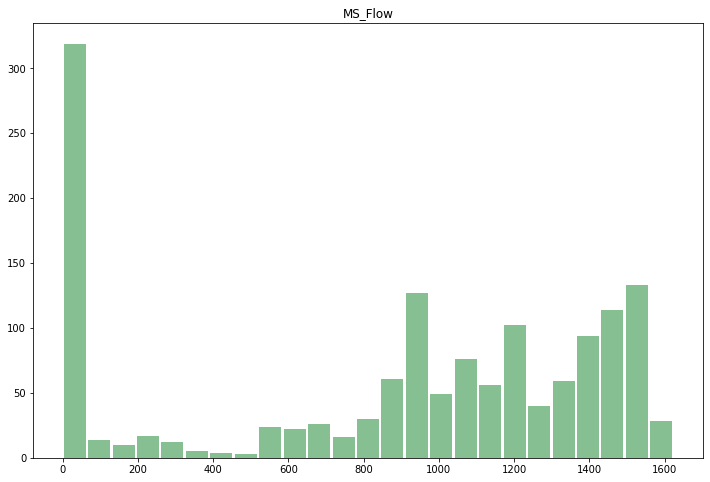

In [624]:
                              
ax = df_series_withou_Ni.hist(column='MS_Flow', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)                              

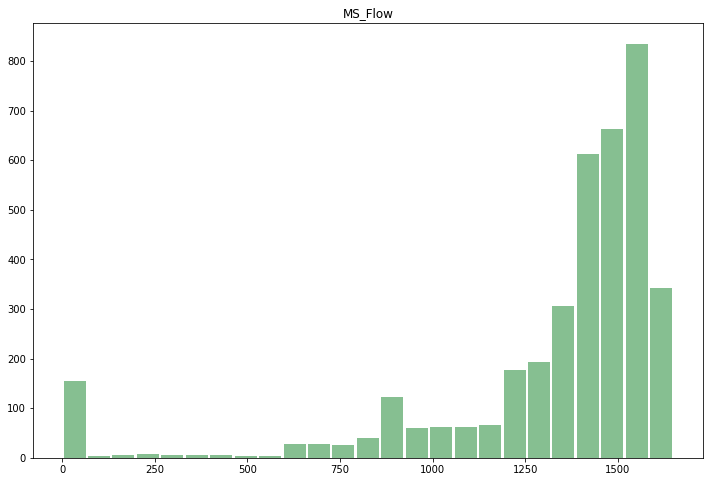

In [626]:
ax_single = df_single_without_Ni.hist(column='MS_Flow', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)                              

In [623]:
df_series_withou_Ni.columns

Index(['H2S Flow', 'NaOH_to_SR03', 'FR_106TK15_TO_106SR03',
       'FR_106TK15_TO_106SR04', '109SR03_Disch_To_106SR03',
       '109SR04_Disch_106SR03', '106FN02A_OP', '106FN02B_OP',
       'FN02_SUCT_PRESS', 'FN11_SUCT_PRESS', 'FN11A_OP', 'FN11B_OP',
       'SR03_H2S_CONC_A', 'SR03_H2S_CONC_B', 'MS_Flow', 'HV700 position',
       'SR_status', 'Total_NaOH_SR03_04', 'MS_Flow_to_Gas_Ratio',
       'Gas_to_MS_flow_Ratio'],
      dtype='object')

In [622]:
figMSscrubberNaOH.write_image(r'C:\Users\v.t.flores\Documents\NaOH Consumption Comparison Single-Series.png')

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    C:\ProgramData\Anaconda3
    C:\ProgramData\Anaconda3\Library\mingw-w64\bin
    C:\ProgramData\Anaconda3\Library\usr\bin
    C:\ProgramData\Anaconda3\Library\bin
    C:\ProgramData\Anaconda3\Scripts
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\iCLS\
    C:\Program Files\Intel\Intel(R) Management Engine Components\iCLS\
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0\
    C:\WINDOWS\System32\OpenSSH\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files (x86)\PIPC\bin\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\iCLS\
    C:\Program Files\Intel\Intel(R) Management Engine Components\iCLS\
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0\
    C:\WINDOWS\System32\OpenSSH\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files (x86)\PIPC\bin\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\iCLS\
    C:\Program Files\Intel\Intel(R) Management Engine Components\iCLS\
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0\
    C:\WINDOWS\System32\OpenSSH\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files (x86)\PIPC\bin\
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\iCLS\
    C:\Program Files\Intel\Intel(R) Management Engine Components\iCLS\
    C:\WINDO

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


In [616]:
#-------------MS Operation: 106VE04, 106TK01
#
figMSscrubberNaOH = px.scatter(df_scrubber_caustic_cons_MS_Flow, 
                  x= df_scrubber_caustic_cons_MS_Flow.index,
                  y='Single_Total_NaOH_SR03_04')
figMSscrubberNaOH

In [525]:
#-------------MS Operation: 106VE04, 106TK01
#
figMSscrubberNaOH_single = px.scatter(df_single_without_Ni, 
                  x= 'MS_Flow',
                  y='Total_NaOH_SR03_04')
figMSscrubberNaOH_single

In [526]:
#-------------MS Operation: 106VE04, 106TK01
#
figMSscrubberNaOH_ser = px.scatter(df_series_withou_Ni, 
                  x= 'MS_Flow',
                  y='Total_NaOH_SR03_04')
figMSscrubberNaOH_ser

In [538]:
ave_caustic_per_MS_flow_series = df_series_withou_Ni.groupby(['MS_Flow'])['Total_NaOH_SR03_04'].mean()
ave_caustic_per_MS_flow_single = df_single_without_Ni.groupby(['MS_Flow'])['Total_NaOH_SR03_04'].mean()

In [547]:
df_series_withou_Ni.groupby(['MS_Flow'])[['Total_NaOH_SR03_04', 'MS_Flow_to_Gas_Ratio']].mean()

,Total_NaOH_SR03_04,MS_Flow_to_Gas_Ratio
MS_Flow,,
-0.923402,0.10857,0.919570
-0.491654,0.07739,0.464555
-0.291038,0.19984,-0.423329
-0.132172,0.00000,0.122951
-0.053949,0.00000,0.049991
...,...,...
1601.539524,1.19970,0.778484
1603.736723,1.30016,0.825596
1604.587903,1.20059,0.774935


##### Join Pi data and 106TK01 Ni analysis

In [40]:
# Join the Pi data and the MSTK01 Ni dataframes
# Drop the Nan values
df_Pi_MSoprtn1_Ni = df_Pi_MSoprtn1.join(MSTK01_Ni, how='outer')
df_Pi_MSoprtn1_Ni = df_Pi_MSoprtn_Ni.dropna(how='any')
#
#
# Create a column called the total caustic consumption of SR03 and SR04
# Create a column called the Ni input factor computed by (MS flow / H2S flow)*Ni input
df_Pi_MSoprtn1_Ni['Total_NaOH_SR03_04'] = df_Pi_MSoprtn1_Ni['FR_106TK15_TO_106SR03'] + df_Pi_MSoprtn1_Ni['FR_106TK15_TO_106SR04']
df_Pi_MSoprtn1_Ni['Nickel_input_factor'] = df_Pi_MSoprtn1_Ni['MS_Flow']*df_Pi_MSoprtn1_Ni['106TK01_Ni']/df_Pi_MSoprtn1_Ni['H2S Flow']

In [152]:
# temp code
# 
#df_Pi_MSoprtn1_Ni.loc['2020-01-24 12:00:00':'2020-01-25 06:00:00'][['MS_Flow','SIN_SER','106TK01_Ni','Total_NaOH_SR03_04','Nickel_input_factor']]

df_Pi_MSoprtn1.columns

Index(['H2S Flow', 'NaOH_to_SR03', 'FR_106TK15_TO_106SR03',
       'FR_106TK15_TO_106SR04', '109SR03_Disch_To_106SR03',
       '109SR04_Disch_106SR03', '106FN02A_OP', '106FN02B_OP',
       'FN02_SUCT_PRESS', 'FN11_SUCT_PRESS', 'FN11A_OP', 'FN11B_OP',
       'SR03_H2S_CONC_A', 'SR03_H2S_CONC_B', 'MS_Flow', 'SIN_SER'],
      dtype='object')

In [75]:
# Separate the dataframes into series and single scrubber operation
df_single = df_Pi_MSoprtn1_Ni[df_Pi_MSoprtn1_Ni['SIN_SER'] == 'SINGLE']
df_series = df_Pi_MSoprtn1_Ni[df_Pi_MSoprtn1_Ni['SIN_SER'] == 'SERIES']

In [57]:
#export the dataframe to excel
df_single.to_excel(r'C:\Users\v.t.flores\Documents\SR03_single_2020_0107.xlsx')
df_series.to_excel(r'C:\Users\v.t.flores\Documents\SR03_04_series_2020_0107.xlsx')

In [79]:
# ! This code block  may not be necessary later on. Check carefully before running this code block
#
# create a new column called the difference in time between the previous time and the present
# first, reset the index to access the datetime. Then add 1 hr.
# Get the difference. If more than 1 hr, this means the HV700 changed in status.
df_series_new_DT = df_series.reset_index()

df_series_new_DT['dt_diff'] = df_series_new_DT['DATETIME'][0:] - df_series_new_DT['DATETIME'][1:]

#create a column to check if the datetime column was continuous. This will help suggest that the HV700 changed position
df_series_new_DT['skipped_hours'] = [str(x).split(" ")[-1] for x in df_series_new_DT['dt_diff']]

df_series_new_DT['skipped_hours'][1:] = [parse(x).hour for x in df_series_new_DT['skipped_hours'][1:]]

In [54]:
#---------  Plotting the scrubber series df

figseries = make_subplots(specs=[[{"secondary_y": True}]])
figseries_axis_truefalse_list = [False, False, False, True, True, 
                            True, True, True, True, True, 
                            True, True, True, False, True,
                                True, True, False, True]
generate_plot_from_df(figseries, df_series, figseries_axis_truefalse_list)

#title_plot = 'Zn Drop Trend InterActive \n' + '\n Updated as of: ' + str(datetime.datetime.now())
title_plotseries = "<b>series SR03 04</b>" + '<br>'
figseries.update_layout(title_text=title_plotseries)
figseries.update_xaxes(title_text="DateTime") # Set x-axis title
#figMSTK01.update_yaxes(title_text="Pb, Zn , Cu, Co, Cr, Ca, Si, Fe, ZnNi", secondary_y=False) # Set y-axes titles primary axis
#figMSTK01.update_yaxes(title_text="Ni, Mg, Al, Mn, pH, ORP", secondary_y=True) # Set y-axes titles secondary axis

#-------------------------------------------------------------------------End----------------------------------------------------------------------------

In [687]:
#-----------------------------------------------------------------Exporting to an HTML file--------------------------------------------------------------

with open(r'C:\Users\v.t.flores\Documents\Caustic Consumption 2020.html', 'w') as f:
    f.write(figMSscrubberNaOH.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_series_single_hist.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_NaOH_series_single.to_html(full_html=False, include_plotlyjs='cdn'))

#-------------------------------------------------------------------------End----------------------------------------------------------------------------